In [1]:
# config
fits_base_dir = '/Users/Shared/oca_data/fits'  # /data/fits
telescope = 'jk15'
fltr = 'V'
master_flat = 'jk15c_0688_90272'

# Shutter map from random FLATS series

In [2]:
from pathlib import Path
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
flats_series_path = Path(fits_base_dir) / telescope / 'processed-ofp/flats' / fltr / master_flat

### Collecting data
Flat Field serie:

In [4]:
flat_files = list(flats_series_path.glob(f'{telescope}?_????_?????.fits'))
print('\n'.join([f.name for f in flat_files]))

jk15c_0688_90272.fits
jk15c_0688_90077.fits
jk15c_0688_90175.fits
jk15c_0688_89847.fits
jk15c_0688_89499.fits
jk15c_0688_89704.fits
jk15c_0688_89971.fits


Master ZERO (BIAS) and DARK frames

In [5]:
zero_file_pattern = f'{telescope}?_????_?????_master_z.fits'
dark_file_pattern = f'{telescope}?_????_?????_master_d.fits'
zero_file = list(flats_series_path.glob(zero_file_pattern))[0]
dark_file = list(flats_series_path.glob(dark_file_pattern))[0]

zero = pyfits.open(zero_file)[0].data
# dark data and exptime
dark_hdu = pyfits.open(dark_file)[0]
dark = dark_hdu.data
dark_exptime = float(dark_hdu.header['EXPTIME'])

print(f"Zero frame: {zero_file.name}")
print(f"Dark frame: {dark_file.name}   exptime={dark_exptime}")

Zero frame: jk15c_0688_85238_master_z.fits
Dark frame: jk15c_0672_81664_master_d.fits   exptime=600.0


Load files data into numpy qube $D$, and exposure time vector $t$

In [6]:
_data = []
_exptime = []
for p in flat_files:
    with pyfits.open(p) as hdul:
        _exp  = float(hdul[0].header['EXPTIME'])
        print(f'Loading {p.name} exptime={_exp}')
        d = hdul[0].data - zero - dark * _exp / dark_exptime
        _data.append(d)
        _exptime.append(_exp)

flats = np.array(_data)       # shape: (N_images, ny, nx)
exposures = np.array(_exptime, dtype=float)
N_images, ny, nx = flats.shape

print(f"Wczytano {N_images} flatfieldów. Rozmiar CCD: {ny} x {nx} px.")
print("Czasy ekspozycji (s):", exposures)

del _data, _exptime

Loading jk15c_0688_90272.fits exptime=7.840201960371446
Loading jk15c_0688_90077.fits exptime=16.152285936483242
Loading jk15c_0688_90175.fits exptime=11.261793625958573
Loading jk15c_0688_89847.fits exptime=36.50228621939623
Loading jk15c_0688_89499.fits exptime=107.68650457173034
Loading jk15c_0688_89704.fits exptime=58.06803640370336
Loading jk15c_0688_89971.fits exptime=23.74066412362226
Wczytano 7 flatfieldów. Rozmiar CCD: 4096 x 4108 px.
Czasy ekspozycji (s): [  7.84020196  16.15228594  11.26179363  36.50228622 107.68650457
  58.0680364   23.74066412]


In [8]:
# Oblicz medianę każdego obrazu flat
medians = np.median(flats, axis=(1,2))   # mediany wzdłuż osi (y,x) dla każdej klatki

# Normalizacja – dzielimy każdy obraz przez jego medianę (skalujemy około 1.0)
norm_flats = flats / medians[:, np.newaxis, np.newaxis]

# Opcjonalnie: można zamiast median użyć np. średniej z górnych 10% pikseli
# jako reprezentacji jasności nieba, aby zminimalizować wpływ migawki (która najmniej wpływa na górę).

In [23]:
# Obraz referencyjny - medianowy flat z już wstępnie wyrównanych danych
median_flat = np.median(norm_flats, axis=0)   # kształt (ny, nx)

# Inicjalizacja maski outlierów: False = brak maskowania, True = piksel do pominięcia
outlier_mask = np.zeros_like(norm_flats, dtype=bool)  # shape (N_images, ny, nx)

# Ustalmy próg odchyłki - np. 5-sigma na podstawie median i median absolute deviation
# Najpierw oblicz odchyłkę dla każdego piksela wzdłuż czasu:
abs_dev = np.abs(norm_flats - median_flat)  # absolutne odchylenie każdej wartości od mediany pikselowej
med_abs_dev = np.median(abs_dev, axis=0)    # mediana odchyleń dla każdego piksela (ny,nx)
# Szacuj odchylenie standardowe z median absolute deviation (MAD):
sigma_map = 1.4826 * med_abs_dev            # 1.4826 * MAD ~ std dla rozkładu normalnego

threshold = 15.0
# Wyznacz maskę: gdzie |wartość - mediana| > threshold * sigma
for j in range(N_images):
    # True w miejscach, gdzie dany piksel w klatce j odchyla się ponad threshold*sigma_map
    outlier_mask[j] = np.abs(norm_flats[j] - median_flat) > (threshold * sigma_map)

# (Powyższa pętla można wektorowo, ale jawnie jest czytelniejsza. Dla dużej liczby obrazów i pikseli
# warto użyć funkcji astropy.stats.sigma_clip, która potrafi automatycznie iteracyjnie maskować.)

In [24]:
import numpy as np
from astropy.io import fits

# Załóżmy, że norm_flats ma kształt (N_images, ny, nx) – znormalizowane skyflaty
# outlier_mask ma ten sam kształt (True = zły piksel)
# exposures to tablica (N_images,) z czasami ekspozycji w sekundach
# np.:
# norm_flats = np.array([...])
# outlier_mask = np.array([...], dtype=bool)
# exposures = np.array([...], dtype=float)

# Przekształć exposures do kształtu (N_images, 1, 1) dla broadcastingu
T_vec = exposures.reshape(-1, 1, 1)

# Utwórz masked array z danymi flatów z uwzględnieniem outlier_mask
D_ma = np.ma.array(norm_flats, mask=outlier_mask)

# Liczba poprawnych (ważnych) pomiarów dla każdego piksela (kształt: (ny, nx))
n_valid = D_ma.count(axis=0)

# Aby obliczyć sumy, musimy mieć maskę jako float (True=1 dla ważnych, False=0)
valid_f = (~outlier_mask).astype(float)

# Oblicz sumy T, T^2 oraz T*D dla każdego piksela (suma po osi 0 – przez obrazy)
sumT  = np.sum(T_vec * valid_f, axis=0)
sumT2 = np.sum(T_vec**2 * valid_f, axis=0)
sumD  = np.ma.sum(D_ma, axis=0).data       # sumy z danych (pomijamy maskowane)
sumTD = np.ma.sum(T_vec * D_ma, axis=0).data

# Oblicz współczynnik regresji (slope) i intercept dla każdego piksela:
# Formuły: slope = (n*sum(T*D) - sum(T)*sum(D)) / (n*sum(T^2) - (sum(T))^2)
#           intercept = (sum(D) - slope*sum(T)) / n
denom = n_valid * sumT2 - sumT**2
slope = (n_valid * sumTD - sumT * sumD) / denom
intercept = (sumD - slope * sumT) / n_valid

# Tam, gdzie n_valid < 2 (za mało punktów) ustawiamy wartości na NaN
slope   = np.where(n_valid < 2, np.nan, slope)
intercept = np.where(n_valid < 2, np.nan, intercept)

# Mapa efektu migawki: Delta t = - (intercept / slope)
shutter_map = -intercept / slope

# Unikamy NaN – zastępujemy je zerem
shutter_map = np.nan_to_num(shutter_map)

# Teraz shutter_map (kształt: (ny, nx)) zawiera dla każdego piksela oszacowane Δt [s]

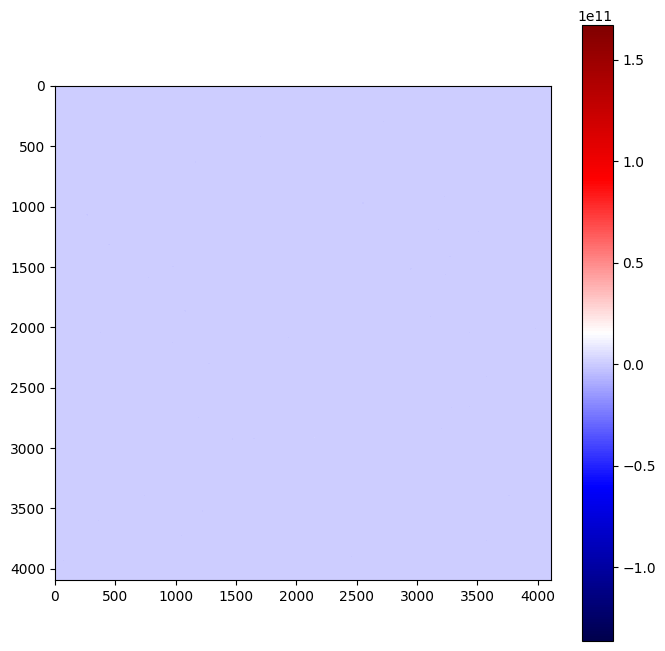

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(shutter_map, cmap='seismic', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()

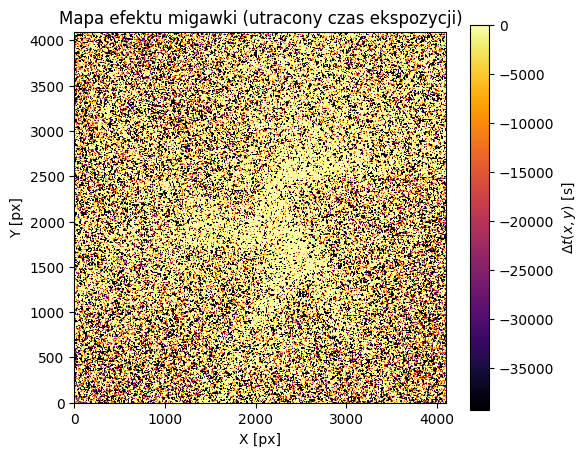

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
# Ustaw zakres kolorów od 0 do max efektu (np. 0.05 s) – wartości powyżej saturujemy
vmax = np.percentile(shutter_map, 20)  # np. 99 percentyl jako approx max bez outlierów
plt.imshow(shutter_map, origin='lower', cmap='inferno', vmin=0, vmax=vmax)
plt.colorbar(label=r'$\Delta t(x,y)$ [s]')
plt.title("Mapa efektu migawki (utracony czas ekspozycji)")
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
plt.show()

/var/folders/fg/2yxbhhsj6c3bh41yk4ll50mc0000gn/T/ipykernel_3428/69997726.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


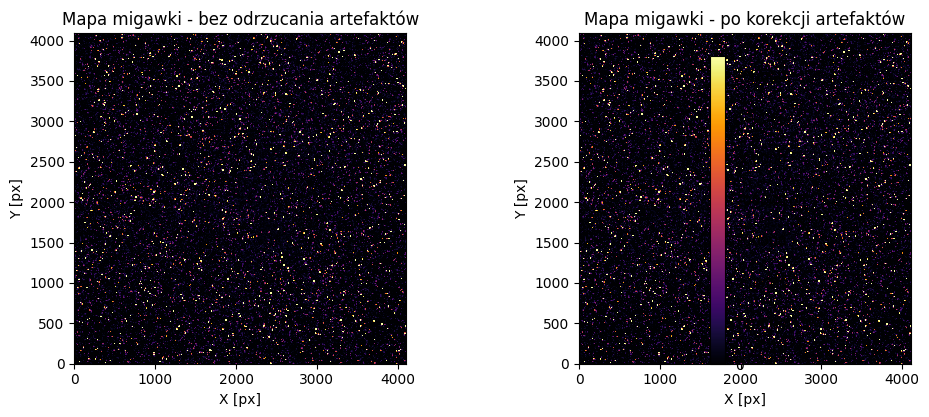

In [27]:
# (Kontynuując, zakładamy że mamy również shutter_map_raw policzoną wcześniej
# bez maski outlierów, analogicznie do shutter_map, dla porównania.)
# Tutaj tylko szkicowo:
shutter_map_raw = shutter_map  # (w rzeczywistym kodzie obliczylibyśmy oddzielnie bez maski)
# Wizualizacja obok siebie
fig, axes = plt.subplots(1, 2, figsize=(10,4))
vmax = np.percentile(shutter_map_raw, 99)
im0 = axes[0].imshow(shutter_map_raw, origin='lower', cmap='inferno', vmin=0, vmax=vmax)
axes[0].set_title("Mapa migawki - bez odrzucania artefaktów")
axes[0].set_xlabel("X [px]"); axes[0].set_ylabel("Y [px]")
im1 = axes[1].imshow(shutter_map, origin='lower', cmap='inferno', vmin=0, vmax=vmax)
axes[1].set_title("Mapa migawki - po korekcji artefaktów")
axes[1].set_xlabel("X [px]"); axes[1].set_ylabel("Y [px]")
plt.colorbar(im1, ax=axes.tolist(), label=r'$\Delta t$ [s]')
plt.tight_layout()
plt.show()

In [8]:
D.shape, t.shape

((7, 4096, 4108), (7,))

### Calculations
#### Normalization

We are looking for median flux vector $F_i = M_i/t_i$ for each image, where $M_i$ is the median ADU of $i$-th image, and $t_i$ is the exposure time of $i$-th image.


In [9]:
M = np.median(D, axis=(1, 2))
F = M / t


Check the values of delivered vectors

In [10]:
for _file, _exp, _flux, _median in zip(flat_files, t, F, M):
    print (f'{_file.name}   median={_median:8.2f} ADU   exp={_exp:7.2f}s   flux={_flux:8.2f} ADU/s')

jk15c_0688_90272.fits   median=48413.90 ADU   exp=   7.84s   flux= 6175.08 ADU/s
jk15c_0688_90077.fits   median=49629.78 ADU   exp=  16.15s   flux= 3072.62 ADU/s
jk15c_0688_90175.fits   median=49062.90 ADU   exp=  11.26s   flux= 4356.58 ADU/s
jk15c_0688_89847.fits   median=51822.97 ADU   exp=  36.50s   flux= 1419.72 ADU/s
jk15c_0688_89499.fits   median=56227.28 ADU   exp= 107.69s   flux=  522.14 ADU/s
jk15c_0688_89704.fits   median=53056.90 ADU   exp=  58.07s   flux=  913.70 ADU/s
jk15c_0688_89971.fits   median=50768.72 ADU   exp=  23.74s   flux= 2138.47 ADU/s


We normalize data cube $D$ by mean flux $F$, to left only effects of exposure time, shutter, and optics on ADU, but not she effects of sky brightness.
Normalized cube: $N_{xyi} = D_{xyi}/F_i$


In [11]:
N = (D/F[:, None, None])
del D   # free memory

#### Fitting $N_{ixy}(t_i)$

For each pixel, we are looking for linear fit across all images, such that $N_{ixy} = a_{xy} t_i + b_{xy}$, where $N$ is a cube of normalized values.

For technical reasons, we will reshape $N$ to 2D array $N'$, where $N'_{ij} = N_{ixy}$, and $j = x + y \cdot 4096$ (if CCD is 4096x4096 pixels).

In [12]:
Np = N.reshape(N.shape[0], -1)
Np.shape

(7, 16826368)

The problem now has a from of $N' = A X$, where $A$ is a projection matrix of $t_i$ values, and $X$ is a coefficient matrix of $a_{xy}$ and $b_{xy}$ values.

In [13]:
A = np.vstack([t, np.ones_like(t)]).T
print(np.matrix(A), f' shape={A.shape}')

[[  7.84020196   1.        ]
 [ 16.15228594   1.        ]
 [ 11.26179363   1.        ]
 [ 36.50228622   1.        ]
 [107.68650457   1.        ]
 [ 58.0680364    1.        ]
 [ 23.74066412   1.        ]]  shape=(7, 2)


We are looking for $X$ such that $X = (A^T A)^{-1}  A^T  N'$. We will use `numpy.linalg.lstsq` to solve this problem in a least squares sense.

In [14]:
X, residuals, rank, s = np.linalg.lstsq(A, Np, rcond=None)
print(f' shape={X.shape}')

 shape=(2, 16826368)


Lets, examine histograms of $a_{xy}$ and $b_{xy}$ values, and the same histogram with single clipped outliers. (4 subplots)

Reshape back, and restore vectors $a_{xy}$ and $b_{xy}$.

In [15]:
a = X[0].reshape(N.shape[1:])
b = X[1].reshape(N.shape[1:])
print(a.shape, b.shape)

(4096, 4108) (4096, 4108)


Plot some horizontal intersections of $a_{xy}$ and $b_{xy}$ values.

### Plot map of $b_{xy}$ values

We will use aggresive color scale to see the details not disturbed by outliers.

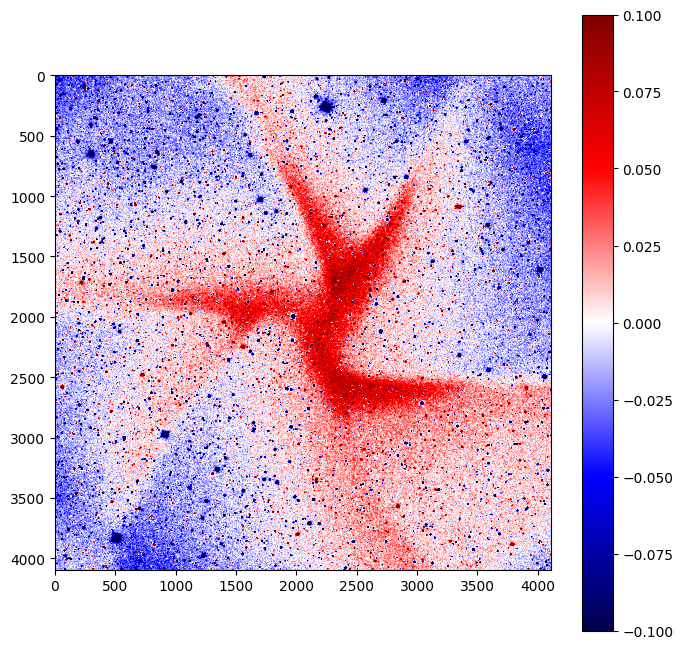

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(b, cmap='seismic', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()